# Flower Species Classification

In this project, flower species classification is carried out using a custom ID3 decision tree algorithm and a custom pruning algorithm. Results before and after pruning are compared, and rule sets are also extracted and compared.

Additionally, a different feature extraction method was attempted using image processing techniques.

## Preprocessing

In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from google.colab.patches import cv2_imshow

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


All images are read and processed, and then matched with the correct labels.

In [ ]:
def load_images(folder_path):
    images = []
    labels = []
    for flower_specie in os.listdir(folder_path):
        flower_specie_path = os.path.join(folder_path, flower_specie)
        if os.path.isdir(flower_specie_path):
            for flower_name in os.listdir(flower_specie_path):
                img_path = os.path.join(flower_specie_path, flower_name)
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)
                    labels.append(flower_specie)
    return np.array(images), np.array(labels)

# Define folder paths
train_folder = '/content/drive/MyDrive/flowers/train'
validation_folder = '/content/drive/MyDrive/flowers/validation'
test_folder = '/content/drive/MyDrive/flowers/test'

# Load images and labels for train, validation, and test
train_images, train_labels = load_images(train_folder)
validation_images, validation_labels = load_images(validation_folder)
test_images, test_labels = load_images(test_folder)


print(f"Number of images in train set: {len(train_images)}")
print(f"Number of images in validation set: {len(validation_images)}")
print(f"Number of images in test set: {len(test_images)}")


<ipython-input-2-978e48113e2c>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(images), np.array(labels)


Number of images in train set: 6000
Number of images in validation set: 500
Number of images in test set: 500


## Feature Extraction

### Color Extraction in ROI (Region of Interest)

The region of interest (ROI) is extracted from the image using the OpenCV library. Subsequently, the dominant colors within this ROI are identified to determine the predominant color in the flower image. In summary, the aim is to extract features based on the dominant colors of the flowers in the image.

The result obtained from Canny edge detection is utilized as a mask to extract the region of interest (ROI). Then, a color mask is applied to the obtained ROI using pre-determined minimum and maximum values for specific colors. By setting a threshold, the highest color values above this threshold are identified, thus applying the color extraction process.

In [ ]:
color_lower_upper_values = [
    [np.array([0, 0, 100]), np.array([10, 10, 255])],       # red, index = 0
    [np.array([0, 100, 0]), np.array([80, 255, 80])],       # green, index = 1
    [np.array([100, 0, 0]), np.array([255, 80, 80])],       # blue, index = 2
    [np.array([200, 200, 200]), np.array([255, 255, 255])], # white, index = 3
    [np.array([80, 0, 80]), np.array([150, 80, 150])],      # purple, index = 4
    [np.array([0, 150, 150]), np.array([80, 255, 255])]     # yellow, index = 5
]                                                           # unclassified, index = 6

def roi_color_extract(image, color_values = color_lower_upper_values, canny_thresholds = [50, 150]):
  # Get the edge detected object using Canny Edge Detector
  edge_detected_object = cv2.Canny(image, canny_thresholds[0], canny_thresholds[1])

  # Get the region of interest (ROI) by applying the edge-detected mask
  roi = cv2.bitwise_and(image, image, mask=edge_detected_object)


  total_roi_pixels = np.sum(roi > 0)
  max_color_percentage = -1
  color_index = 0
  result_index = 6

  for color in color_values:
    # Create masks for each color range
    cmask = cv2.inRange(image, color[0], color[1])

    # Resize the ROI to match the size of the mask
    cmask = cv2.resize(cmask, (roi.shape[1], roi.shape[0]))

    # Apply the mask to the ROI to focus on a specific region
    roi_color = cv2.bitwise_and(roi, roi, mask=cmask)

    # Calculate the percentage of pixels in each color range within the ROI
    color_percentage_roi = np.sum(roi_color > 0) / total_roi_pixels
    #print(f'{color_idxes[color_index]}: {color_percentage_roi}')

    # Define a threshold for dominant color determination
    threshold = 0.01

    # Classify the ROI based on the dominant color
    if color_percentage_roi >= threshold and color_percentage_roi > max_color_percentage:
      max_color_percentage = color_percentage_roi
      result_index = color_index

    # Keep track of color
    color_index += 1

  # Return dominant color in roi
  return result_index


### Grayscale Histogram Intensity Extraction

The image is resized to 64x64 dimensions, converted to grayscale, and then its histogram is calculated, flattening the result. The distribution of intensity values for pixels ranging from 0 to 255 is provided by this process. Recognizing that small differences between nearby values are not crucial and to keep the number of features reasonable, these intensity values are grouped into sets of 16. Ultimately, 16 features are obtained, each representing the count of pixels with intensity values in the ranges 0-15, 16-31, and so on.

In [ ]:
def histogram_extract(image, new_width = 64, new_height = 64):
  # Resize the image
  resized_image = cv2.resize(image, (new_width, new_height))

  # Convert to grayscale
  grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Extract histogram features
  hist = cv2.calcHist(image, [0], None, [256], [0, 256]).flatten()

  # Calculate histogram with intervals of 16
  hist_intervals = []
  for i in range(0, 256, 16):
    interval_sum = 0
    for j in range(16):
      interval_sum += hist[i + j]
    hist_intervals.append(interval_sum)

  return hist_intervals


### Creating Feature Vectors

The obtained dominant color and histogram distribution features are combined to create a feature vector for each image.

In [ ]:
# Create feature vectors by merging extracted color and grayscale histogram

train_features = []
for img in train_images:
  color = roi_color_extract(img)
  features = histogram_extract(img)
  train_features.append([color] + features)

validation_features = []
for img in validation_images:
  color = roi_color_extract(img)
  features = histogram_extract(img)
  validation_features.append([color] + features)

test_features = []
for img in test_images:
  color = roi_color_extract(img)
  features = histogram_extract(img)
  test_features.append([color] + features)

Then, these vectors are converted into Pandas DataFrames to facilitate their use in ID3 (Iterative Dichotomiser 3).

In [ ]:
# Convert vectors into pd.DataFrames
train_df = pd.DataFrame(train_features, columns=['color'] + [f'Feature_{i}' for i in range(1, len(train_features[0]))])
validation_df = pd.DataFrame(validation_features, columns=['color'] + [f'Feature_{i}' for i in range(1, len(validation_features[0]))])
test_df = pd.DataFrame(test_features, columns=['color'] + [f'Feature_{i}' for i in range(1, len(test_features[0]))])

y_train_df = pd.DataFrame(data={'Label': train_labels})
y_validation_df = pd.DataFrame(data={'Label': validation_labels})
y_test_df = pd.DataFrame(data={'Label': test_labels})

# Discretize histogram intensity values by using mean of values
feature_means = train_df.drop('color', axis=1).mean()
i=1
for feature_mean in feature_means:
    f_name = f"Feature_{i}"
    i+=1
    train_df[f_name] = np.where(train_df[f_name] > feature_mean, 1, 0)
    validation_df[f_name] = np.where(validation_df[f_name] > feature_mean, 1, 0)
    test_df[f_name] = np.where(test_df[f_name] > feature_mean, 1, 0)

# Concatenate label DataFrames with feature DataFrames
train_df = pd.concat([train_df, y_train_df], axis=1)
validation_df = pd.concat([validation_df, y_validation_df], axis=1)
test_df = pd.concat([test_df, y_test_df], axis=1)

## ID3 Implementation


### Calculating Information Gain
The entropy function below computes the entropy of a given feature in a dataset. Entropy is a measure of impurity or disorder in a set of data. The function takes a DataFrame (df) and the name of the label column (class_name). It calculates the entropy by considering the unique labels in the dataset, their frequencies, and then applies the entropy formula using base-2 logarithm.



In [ ]:
"""calculate the entropy of the given feature (df), with (class_name) being the name of the Label column"""
def entropy(df, class_name):
    #set of labels this 'row' can assume, we ignore possible
    #labels not represented in this subset of the df since
    #they'd have an entropy of 0 anyway
    unique_classification = df[class_name].unique()

    #number of rows
    df_count = df.shape[0]

    entropy = 0
    for classification in unique_classification:
          class_count = len(df[df[class_name] == classification].index)
          p_classification = (class_count / df_count)
          #is it really necessary to account for the p_classification == 0 case?
          entropy += 0 if p_classification==0 else -p_classification * math.log(p_classification, 2)
    return entropy

The info_gain function calculates the information gain of a specific feature in a DataFrame. It employs the entropy function to calculate the entropy of the entire dataset and then subtracts the entropy of subsets created by splitting the data based on the values of the given feature.



In [ ]:
"""find info gain of this feature called the feature_name"""
def info_gain(df_general, feature_name, class_name, entropy_df_general = -1):
    if entropy_df_general < 0:
        entropy_df_general = entropy(df_general, class_name)

    #uniq_features:   different values this feature assumes. We ignore possible features that do
    #not appear in the dataset, for they couldn't provide any info gain.
    unique_features = df_general[feature_name].unique()
    info_gain = entropy_df_general
    #for
    for feature in unique_features:
        #those entries in the dataset with 1 fixated feature.
        sub_df_w_feature = df_general[df_general[feature_name]==feature]
        info_gain -= entropy(sub_df_w_feature, class_name)
    return info_gain

### The Decision Tree
The 'node' is a simple structure representing a node in the Decision Tree. Has references to it's child nodes, has an attribute that defines it's relation to it's parent node, and has an attribute that defines how it interacts with it's own childeren. Has a max_label, a useful attribute that stores the result of the majority vote taken at the time of node creation. And the label is reserved for leaf nodes.

In [ ]:
"""simple class that stores the data needed in a node"""
class node:
    def __init__(self, parent_node=None, label = None, child_attribute = None, parent_attribute = None):
        self.parent = parent_node
        self.label = label
        self.name = child_attribute       #best info gain attribute of this node
        self.feature = parent_attribute   #forward rows with this feature from the parent class
        self.child = None
        self.max_label=None
        self.rule = ""

The build_tree function recursively constructs a decision tree. It takes a root node, a local DataFrame, and the name of the label column. The decision tree is built by iteratively selecting the feature with the highest information gain and creating child nodes accordingly. The process continues until either the data is homogeneous or no more features are available, at which point a label is assigned to the leaf node.

In [ ]:
"""builds a tree recursively"""
def build_tree(curr_node, local_df, class_name):
    local_classes = local_df[class_name].unique() #possible labels
    is_homogeneous = local_classes.shape[0]==1    #homogeneous if only 1 class present here
    curr_node.max_label = local_df[class_name].value_counts().idxmax()
    if is_homogeneous or local_df.shape[1]==1:
        #if homogeneous OR ran out of features :    take a majority vote
        curr_node.label = curr_node.max_label
        return
    #OTHERWISE, create and populate child nodes, for the feature with best info gain.
    curr_node.child = []

    #entropy of the dataset associated with this node.
    entropy_general = entropy(local_df, class_name)

    #find best feature in the dataset associated with this node
    best_feature = max(local_df.drop(columns = [class_name]).columns, key = lambda feature : info_gain(local_df, feature, class_name, entropy_general))
    curr_node.name = best_feature
    for feature in local_df[best_feature].unique():
        new_node = node(curr_node, parent_attribute=feature)
        new_node.rule = f"{curr_node.rule} {best_feature} = {feature} ->"
        #add child
        curr_node.child.append(new_node)
        #build a subtree with child as root.
        build_tree(new_node, local_df[local_df[best_feature]==feature].drop(columns = [best_feature]), class_name)



def print_rules(node, class_name):
    if node.label is not None:
        print(f"Rule: {node.rule} Class: {node.label}")
    else:
        for child in node.child:
            print_rules(child, class_name)


The DecisionTree class represents the decision tree model. It includes methods for fitting the tree to a given dataset, testing the model on new data, predicting labels, and a method for pruning the tree based on a validation dataset.

In [ ]:
"""Decision tree class. Can be used to build, test, prune decision trees."""
class DecisionTree:
    def __init__(self):
        self.root = None
    def fit(self, df, class_name):
        #build a decision tree from the dataset provided, with class_name assigned as the label column
        self.root = node()
        self.class_name = class_name
        self.class_list = df[class_name].unique()
        build_tree(self.root, df, class_name)
    def test(self, vector):
        #predict a label for vector.

        #start at the root node, and traverse down the list
        curr_node = self.root

        #while no label is assigned to the current node, continue
        while curr_node.label is None:
            #denotes that the node has a child
            child_found = False

            #find the matching child to the input vector
            for child in curr_node.child:
                if child.feature == vector[curr_node.name]:
                    curr_node = child
                    child_found = True
                    break
            #if the current node doesn't have a child, then it must be that the features of the dataset is exhausted,
            #and a majority vote is taken to assign a label to this leaf node.
            if not child_found:
                return curr_node.max_label
        return curr_node.label
    def predict(self, test_df):
        #predict each element separately, return the resulting vector.
        return test_df.apply(self.test,axis = 1)

    def prune(self, node, validation_df, class_name):
        if node.label is not None:
            return

        # Recursively prune child nodes
        for child in node.child:
            self.prune(child, validation_df, class_name)

        # Backup current state
        backup_label = node.label
        backup_child = node.child

        # Set current node as leaf and calculate accuracy on validation set
        node.label = node.max_label
        node.child = None
        predicted_labels = self.predict(validation_df)
        accuracy_after_prune = accuracy_score(validation_df[class_name], predicted_labels)

        # If accuracy improves, keep the pruning; otherwise, revert to the original state
        if accuracy_after_prune >= self.accuracy_before_prune:
            self.accuracy_before_prune = accuracy_after_prune
        else:
            node.label = backup_label
            node.child = backup_child

##Running And Testing

Create an ID3 instance and fit the train dataframe.

In [ ]:
d_tree = DecisionTree()
d_tree.fit(train_df, 'Label')
df22 = d_tree.predict(test_df)

### Classification Metrics Calculation

A function for calculating and visualizing metrics such as accuracy, precision, recall, F1 score and Confusion Matrix:

In [ ]:
def calculate_result_metrics(y_true, y_pred):
  # Calculate and show result metrics
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='weighted')
  recall = recall_score(y_true, y_pred, average='weighted')
  f1 = f1_score(y_true, y_pred, average='weighted')

  metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
  values = [accuracy, precision, recall, f1]

  # Plotting
  plt.figure(figsize=(8, 5))
  bars = plt.barh(metrics, values, color=['blue', 'green', 'orange', 'red'])

  # Annotate the bars with their values
  for bar, value in zip(bars, values):
      plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height() / 2, f'{value:.3f}', ha='center', va='center')

  plt.xlim(0, 1)  # Set the x-axis limit to [0, 1] for better visualization
  plt.title('Performance Metrics')
  plt.xlabel('Score')
  plt.show()

  # Generate and show confusion matrix
  conf_matrix = confusion_matrix(y_true, y_pred)

  plt.figure(figsize=(8, 5))
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
              xticklabels=sorted(y_true.unique()),
              yticklabels=sorted(y_true.unique()))
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()

  # Generate and show classification report
  class_report = classification_report(y_true, y_pred)

  # Visualize the classification report as a heatmap
  report_dict = classification_report(y_true, y_pred, target_names=sorted(y_true.unique()), output_dict=True)
  df_report = pd.DataFrame(report_dict).transpose()

  # Plotting
  plt.figure(figsize=(8, 5))
  sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="Reds", fmt=".3f", linewidths=.5, cbar=False)
  plt.title('Classification Report')
  plt.show()


### Error Analysis for Classification Before Pruning

#### Metrics

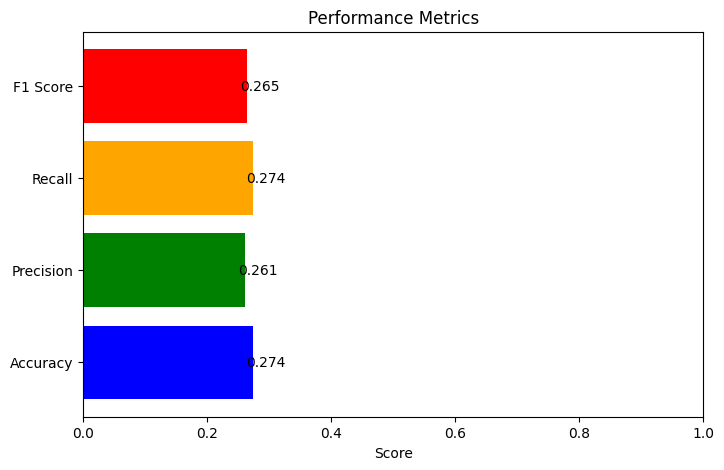

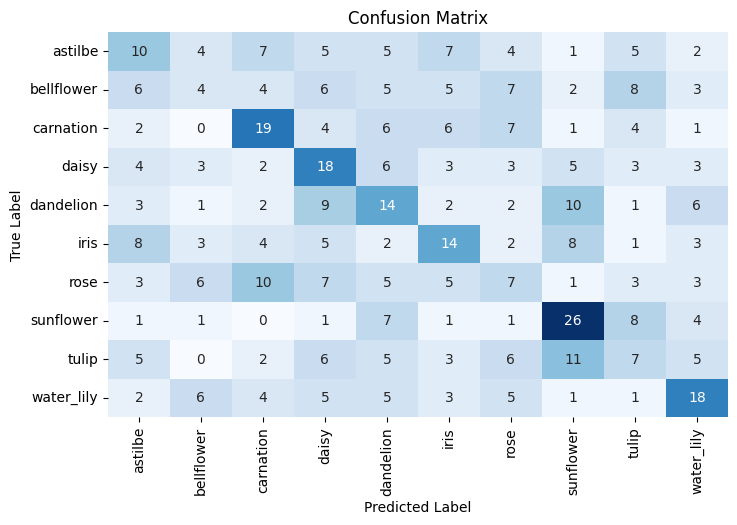

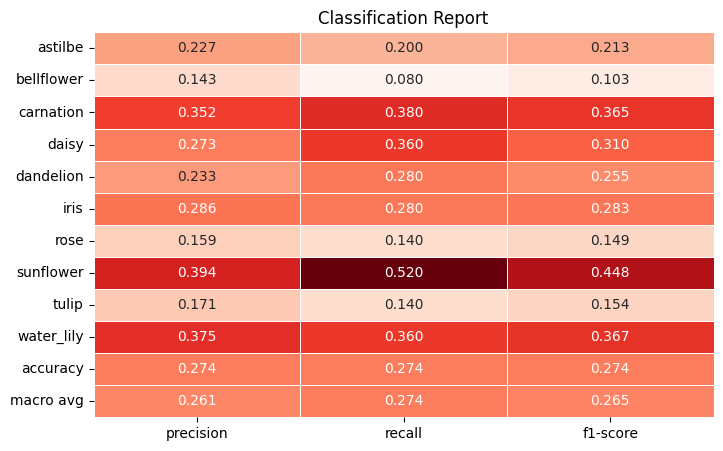

In [ ]:
# Before pruning
calculate_result_metrics(y_test_df['Label'], y_pred = df22)

When the values before pruning are examined, it is observed that the accuracy, precision, recall, and F1 score are around **0.25**, approximately **25%**. While this value is not high, it can be considered a reasonable result, given that the dataset may not be well-suited for this problem. Furthermore, the closeness of these values (especially precision and recall) suggests that results are consistently produced by the model. However, improvements may be possible through more sophisticated feature extraction methods or dataset adjustments.

Above-average results are observed for classes such as **sunflower**, **water lily**, **carnation**, and **daisy**. Similarly, results for **rose** and **bellflower** classes are found to be below average. This inefficiency of the dataset may be attributed to the observed pattern. Furthermore, when the dataset is examined based on the extracted colors, it is noticed that the colors in classes where above-average results are achieved are similar and consistent, whereas the colors in classes where below-average results are obtained are significantly different and inconsistent.

####Rules

In [ ]:
print("Before pruning rules:")
print_rules(d_tree.root, 'Label')

Before pruning rules:
Rule:  Feature_16 = 0 -> Feature_1 = 0 -> Feature_15 = 0 -> Feature_3 = 0 -> Feature_2 = 0 -> Feature_4 = 0 -> Feature_7 = 1 -> Feature_8 = 1 -> Feature_14 = 0 -> Feature_13 = 0 -> Feature_5 = 1 -> Feature_6 = 1 -> Feature_10 = 1 -> Feature_9 = 0 -> color = 4 -> Feature_11 = 1 -> Feature_12 = 1 -> Class: carnation
Rule:  Feature_16 = 0 -> Feature_1 = 0 -> Feature_15 = 0 -> Feature_3 = 0 -> Feature_2 = 0 -> Feature_4 = 0 -> Feature_7 = 1 -> Feature_8 = 1 -> Feature_14 = 0 -> Feature_13 = 0 -> Feature_5 = 1 -> Feature_6 = 1 -> Feature_10 = 1 -> Feature_9 = 0 -> color = 4 -> Feature_11 = 0 -> Class: bellflower
Rule:  Feature_16 = 0 -> Feature_1 = 0 -> Feature_15 = 0 -> Feature_3 = 0 -> Feature_2 = 0 -> Feature_4 = 0 -> Feature_7 = 1 -> Feature_8 = 1 -> Feature_14 = 0 -> Feature_13 = 0 -> Feature_5 = 1 -> Feature_6 = 1 -> Feature_10 = 1 -> Feature_9 = 0 -> color = 5 -> Class: sunflower
Rule:  Feature_16 = 0 -> Feature_1 = 0 -> Feature_15 = 0 -> Feature_3 = 0 -> Featur

### Pruning

The decision tree is pruned based on the accuracy values obtained from the validation set. The pruning operation is performed by our pruning algorithm as the accuracy increases. Therefore, while the accuracy with the validation dataset is rising, a slight decrease in accuracy with the test dataset is observed.

In [ ]:
# Save accuracy before pruning
d_tree.accuracy_before_prune = accuracy_score(y_test_df['Label'], d_tree.predict(test_df))
print(f'Accuracy before pruning, calculated with test: {d_tree.accuracy_before_prune}')
print(f'Accuracy before pruning, calculated with validation: {accuracy_score(y_validation_df["Label"], d_tree.predict(validation_df))}')

# Prune the tree
d_tree.prune(d_tree.root, validation_df, d_tree.class_name)

print(f'Accuracy after pruning, calculated with test: {accuracy_score(y_test_df["Label"], d_tree.predict(test_df))}')
print(f'Accuracy after pruning, calculated with validation: {accuracy_score(y_validation_df["Label"], d_tree.predict(validation_df))}')

Accuracy before pruning, calculated with test: 0.274
Accuracy before pruning, calculated with validation: 0.268
Accuracy after pruning, calculated with test: 0.288
Accuracy after pruning, calculated with validation: 0.294


### Error Analysis for Classification After Pruning

#### Metrics

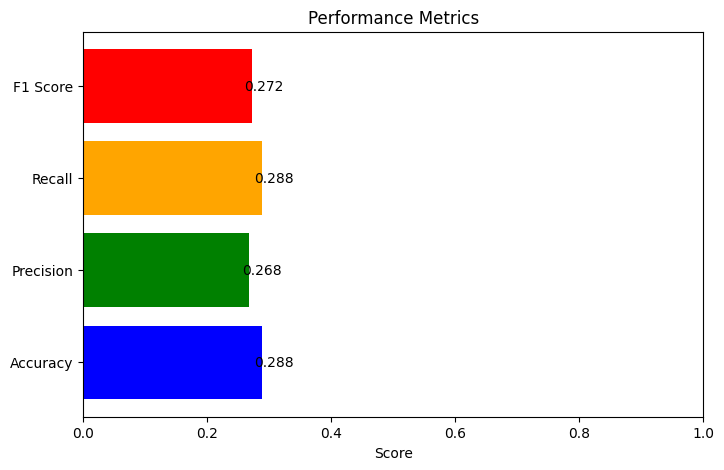

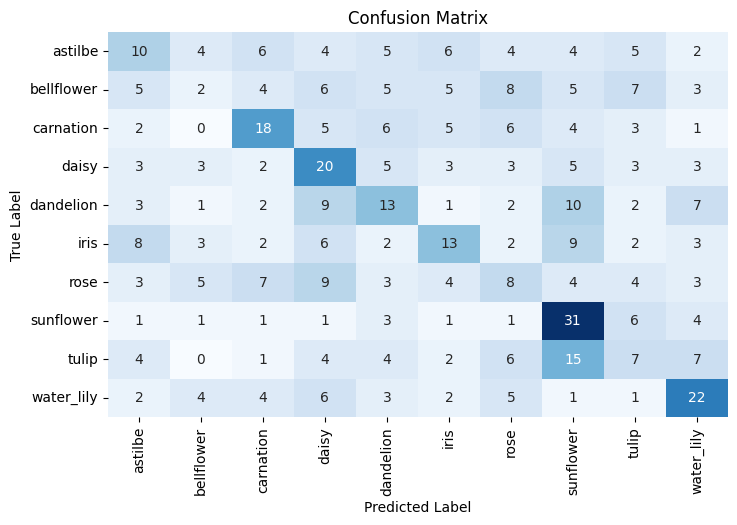

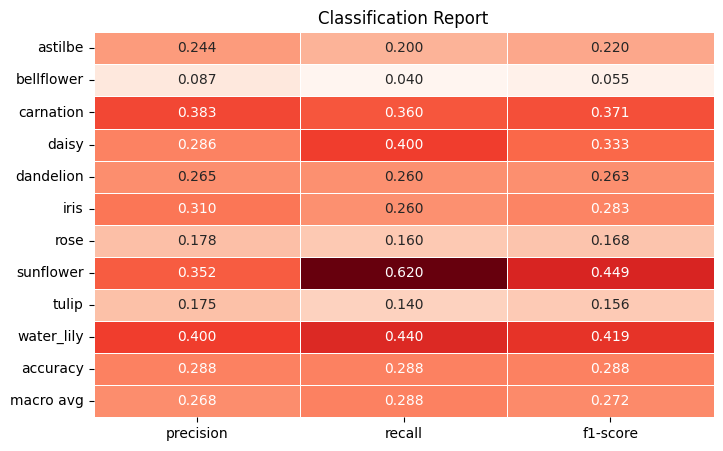

In [ ]:
# After pruning
calculate_result_metrics(y_test_df['Label'], y_pred = d_tree.predict(test_df))

When the values after pruning are examined, it is observed that the accuracy, precision, recall, and F1 score are around **0.21**, approximately **21%**. A decrease in performance after pruning is indicated by these observations. The tree was pruned based on the accuracy results from the validation dataset, which resulted in this outcome. Although the accuracy of the validation dataset increases, a decrease in performance on the test dataset is normal due to the insufficiency and bias of the datasets.

After the pruning process, it is observed that high metric values are maintained by the **sunflower** and **water lily** classes, while the results for the **carnation** and **daisy** classes decline to an average level. Meanwhile, although the performance of the **rose** class improves, a dramatic decrease is noticed in the **dandelion** and **bellflower** classes.

#### Rules

In [ ]:
print("After pruning rules:")
print_rules(d_tree.root, 'Label')

After pruning rules:
Rule:  Feature_16 = 0 -> Feature_1 = 0 -> Feature_15 = 0 -> Feature_3 = 0 -> Feature_2 = 0 -> Feature_4 = 0 -> Feature_7 = 1 -> Feature_8 = 1 -> Feature_14 = 0 -> Feature_13 = 0 -> Feature_5 = 1 -> Feature_6 = 1 -> Feature_10 = 1 -> Feature_9 = 0 -> color = 4 -> Feature_11 = 1 -> Feature_12 = 1 -> Class: carnation
Rule:  Feature_16 = 0 -> Feature_1 = 0 -> Feature_15 = 0 -> Feature_3 = 0 -> Feature_2 = 0 -> Feature_4 = 0 -> Feature_7 = 1 -> Feature_8 = 1 -> Feature_14 = 0 -> Feature_13 = 0 -> Feature_5 = 1 -> Feature_6 = 1 -> Feature_10 = 1 -> Feature_9 = 0 -> color = 4 -> Feature_11 = 0 -> Class: bellflower
Rule:  Feature_16 = 0 -> Feature_1 = 0 -> Feature_15 = 0 -> Feature_3 = 0 -> Feature_2 = 0 -> Feature_4 = 0 -> Feature_7 = 1 -> Feature_8 = 1 -> Feature_14 = 0 -> Feature_13 = 0 -> Feature_5 = 1 -> Feature_6 = 1 -> Feature_10 = 1 -> Feature_9 = 0 -> color = 5 -> Class: sunflower
Rule:  Feature_16 = 0 -> Feature_1 = 0 -> Feature_15 = 0 -> Feature_3 = 0 -> Feature

### Rule Differences and Result Comparison

When examining the rules obtained from ID3, it is observed that the highest information gain is generally achieved from extreme values of intensity, leading to our tree's initial splits being based on these values (e.g., **Feature_16** or **Feature_1**). Additionally, **color** feature is typically considered in the final steps of the rules.

*   ***Rule:  Feature_16 = 1 -> Feature_1 = 0 -> Feature_3 = 0 -> Feature_2 = 0 -> Feature_4 = 0 -> Feature_14 = 1 -> Feature_15 = 1 -> Feature_13 = 1 -> Feature_11 = 0 -> Feature_5 = 0 -> Feature_7 = 0 -> Feature_6 = 0 -> Feature_10 = 0 -> Feature_9 = 0 -> Feature_8 = 0 -> Feature_12 = 0 -> color = 5 -> Class: sunflower***

*   ***Rule:  Feature_16 = 1 -> Feature_1 = 0 -> Feature_3 = 0 -> Feature_2 = 0 -> Feature_4 = 0 -> Feature_14 = 1 -> Feature_15 = 1 -> Feature_13 = 1 -> Feature_11 = 0 -> Feature_5 = 0 -> Feature_7 = 0 -> Feature_6 = 0 -> Feature_10 = 0 -> Feature_9 = 0 -> Feature_8 = 0 -> Feature_12 = 0 -> color = 1 -> Class: dais***

*(Reminder: A feature value being 0 is its value is below average in that feature group, and vice versa for being 1. Color is: 0-red, 1-green, 2-blue, 3-white, 4-purple, 5-yellow, 6-unclassified.)*

When comparing the rules before and after pruning, a significant reduction in the number of rules is observed, as expected. The rule count decreases from **2144** before pruning to only **308** after pruning.

Either the color feature or close intensity value groups are pruned by the algorithm (e.g., **Feature_12** and **Feature_13**) to achieve a result. While pruning close intensity value groups to obtain a simpler and better result makes logical sense, it is observed that a decrease in accuracy and other metrics because it prunes the color feature based on the validation set.

e.g. Pruning of color feature:

Before pruning:

*   ***Rule:  Feature_16 = 1 -> Feature_1 = 0 -> Feature_3 = 0 -> Feature_2 = 0 -> Feature_4 = 0 -> Feature_14 = 1 -> Feature_15 = 1 -> Feature_13 = 1 -> Feature_11 = 0 -> Feature_5 = 0 -> Feature_7 = 0 -> Feature_6 = 0 -> Feature_10 = 0 -> Feature_9 = 0 -> Feature_8 = 0 -> Feature_12 = 1 -> color = 5 -> Class: sunflower***

*   ***Rule:  Feature_16 = 1 -> Feature_1 = 0 -> Feature_3 = 0 -> Feature_2 = 0 -> Feature_4 = 0 -> Feature_14 = 1 -> Feature_15 = 1 -> Feature_13 = 1 -> Feature_11 = 0 -> Feature_5 = 0 -> Feature_7 = 0 -> Feature_6 = 0 -> Feature_10 = 0 -> Feature_9 = 0 -> Feature_8 = 0 -> Feature_12 = 1 -> color = 1 -> Class: astilbe***

*   ***Rule:  Feature_16 = 1 -> Feature_1 = 0 -> Feature_3 = 0 -> Feature_2 = 0 -> Feature_4 = 0 -> Feature_14 = 1 -> Feature_15 = 1 -> Feature_13 = 1 -> Feature_11 = 0 -> Feature_5 = 0 -> Feature_7 = 0 -> Feature_6 = 0 -> Feature_10 = 0 -> Feature_9 = 0 -> Feature_8 = 0 -> Feature_12 = 1 -> color = 3 -> Class: astilbe***

*   ***Rule:  Feature_16 = 1 -> Feature_1 = 0 -> Feature_3 = 0 -> Feature_2 = 0 -> Feature_4 = 0 -> Feature_14 = 1 -> Feature_15 = 1 -> Feature_13 = 1 -> Feature_11 = 0 -> Feature_5 = 0 -> Feature_7 = 0 -> Feature_6 = 0 -> Feature_10 = 0 -> Feature_9 = 0 -> Feature_8 = 0 -> Feature_12 = 1 -> color = 4 -> Class: astilbe***

*   ***Rule:  Feature_16 = 1 -> Feature_1 = 0 -> Feature_3 = 0 -> Feature_2 = 0 -> Feature_4 = 0 -> Feature_14 = 1 -> Feature_15 = 1 -> Feature_13 = 1 -> Feature_11 = 0 -> Feature_5 = 0 -> Feature_7 = 0 -> Feature_6 = 0 -> Feature_10 = 0 -> Feature_9 = 0 -> Feature_8 = 0 -> Feature_12 = 1 -> color = 6 -> Class: rose***

After pruning:

*   ***Rule:  Feature_16 = 1 -> Feature_1 = 0 -> Feature_3 = 0 -> Feature_2 = 0 -> Feature_4 = 0 -> Feature_14 = 1 -> Feature_15 = 1 -> Feature_13 = 1 -> Feature_11 = 0 -> Feature_5 = 0 -> Feature_7 = 0 -> Feature_6 = 0 -> Feature_10 = 0 -> Feature_9 = 0 -> Feature_8 = 0 -> Feature_12 = 1 -> Class: sunflower***

Above 5 rules pruned with respect to color feature and become above 1 rule classifying as **sunflower**

---

e.g. Pruning of close intensity features:

Before pruning:

*   ***Rule:  Feature_16 = 0 -> Feature_1 = 0 -> Feature_15 = 0 -> Feature_3 = 0 -> Feature_2 = 0 -> Feature_4 = 1 -> Feature_5 = 1 -> Feature_14 = 0 -> Feature_13 = 0 -> Feature_6 = 1 -> Feature_7 = 1 -> Feature_11 = 0 -> Feature_12 = 0 -> Feature_8 = 1 -> Feature_9 = 0 -> Feature_10 = 1 -> color = 2 -> Class: iris***

*   ***Rule:  Feature_16 = 0 -> Feature_1 = 0 -> Feature_15 = 0 -> Feature_3 = 0 -> Feature_2 = 0 -> Feature_4 = 1 -> Feature_5 = 1 -> Feature_14 = 0 -> Feature_13 = 0 -> Feature_6 = 1 -> Feature_7 = 1 -> Feature_11 = 0 -> Feature_12 = 0 -> Feature_8 = 1 -> Feature_9 = 0 -> Feature_10 = 1 -> color = 6 -> Class: rose***

... (many more rules has been pruned)

After pruning:

*   ***Rule:  Feature_16 = 0 -> Feature_1 = 0 -> Feature_15 = 0 -> Feature_3 = 0 -> Feature_2 = 0 -> Feature_4 = 1 -> Feature_5 = 1 -> Feature_14 = 0 -> Feature_13 = 0 -> Feature_6 = 1 -> Feature_7 = 1 -> Feature_11 = 0 -> Feature_12 = 0 -> Feature_8 = 0 -> Class: bellflower***

16 rules has been pruned to 1 rule by removing close intensity features. In this example, Feature_9 and Feature_10 are removed until Feature_8.


